In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image


root_dir = './processed_data'
os.makedirs(root_dir, exist_ok=True)


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])


train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)


train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(
    train_dataset, [train_size, val_size])


def save_dataset_to_disk(dataset, dataset_name, root_dir):
    dataset_dir = os.path.join(root_dir, dataset_name)
    os.makedirs(dataset_dir, exist_ok=True)

    for idx, (image, label) in enumerate(dataset):
        class_dir = os.path.join(dataset_dir, str(label))
        os.makedirs(class_dir, exist_ok=True)

        image = transforms.ToPILImage()(image)
        image_path = os.path.join(class_dir, f'{idx}.png')
        image.save(image_path)


save_dataset_to_disk(train_dataset, 'train', root_dir)
save_dataset_to_disk(val_dataset, 'val', root_dir)
save_dataset_to_disk(test_dataset, 'test', root_dir)

print("Datasets have been saved to the 'processed_data' directory.")

100%|██████████| 169M/169M [00:06<00:00, 24.4MB/s] 


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Datasets have been saved to the 'processed_data' directory.


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


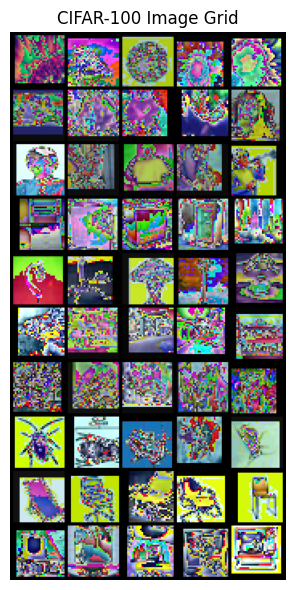

Model Parameters:
features.0.weight: torch.Size([64, 3, 3, 3]) - 1728 parameters
features.0.bias: torch.Size([64]) - 64 parameters
features.1.weight: torch.Size([64]) - 64 parameters
features.1.bias: torch.Size([64]) - 64 parameters
features.3.weight: torch.Size([64, 64, 3, 3]) - 36864 parameters
features.3.bias: torch.Size([64]) - 64 parameters
features.4.weight: torch.Size([64]) - 64 parameters
features.4.bias: torch.Size([64]) - 64 parameters
features.7.weight: torch.Size([128, 64, 3, 3]) - 73728 parameters
features.7.bias: torch.Size([128]) - 128 parameters
features.8.weight: torch.Size([128]) - 128 parameters
features.8.bias: torch.Size([128]) - 128 parameters
features.10.weight: torch.Size([128, 128, 3, 3]) - 147456 parameters
features.10.bias: torch.Size([128]) - 128 parameters
features.11.weight: torch.Size([128]) - 128 parameters
features.11.bias: torch.Size([128]) - 128 parameters
features.14.weight: torch.Size([256, 128, 3, 3]) - 294912 parameters
features.14.bias: torch.Siz

Processing Epoch 1/150
Epoch 1/150
Train Loss: 4.5793, Train Accuracy: 1.46%
Val Loss: 4.5192, Val Accuracy: 1.98%
Processing Epoch 2/150
Epoch 2/150
Train Loss: 4.4804, Train Accuracy: 2.37%
Val Loss: 4.3671, Val Accuracy: 3.44%
Processing Epoch 3/150
Epoch 3/150
Train Loss: 4.4019, Train Accuracy: 3.00%
Val Loss: 4.3147, Val Accuracy: 4.57%
Processing Epoch 4/150
Epoch 4/150
Train Loss: 4.3388, Train Accuracy: 3.50%
Val Loss: 4.2113, Val Accuracy: 5.53%
Processing Epoch 5/150
Epoch 5/150
Train Loss: 4.2729, Train Accuracy: 4.38%
Val Loss: 4.1398, Val Accuracy: 6.36%
Processing Epoch 6/150
Epoch 6/150
Train Loss: 4.1937, Train Accuracy: 5.46%
Val Loss: 4.0657, Val Accuracy: 8.28%
Processing Epoch 7/150
Epoch 7/150
Train Loss: 4.1143, Train Accuracy: 6.32%
Val Loss: 4.0464, Val Accuracy: 8.16%
Processing Epoch 8/150
Epoch 8/150
Train Loss: 4.0326, Train Accuracy: 7.60%
Val Loss: 3.8359, Val Accuracy: 11.24%
Processing Epoch 9/150
Epoch 9/150
Train Loss: 3.9424, Train Accuracy: 8.66%
Va

train_accuracy,▁▁▁▁▂▃▃▃▃▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████
train_loss,██▇▆▆▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▂▃▄▄▄▄▄▆▆▆▆▆▇▇▇▇▇▇▇▇▇████████████████
val_loss,██▇▆▅▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,53.19
train_loss,1.66239
val_accuracy,41.77
val_loss,2.37009


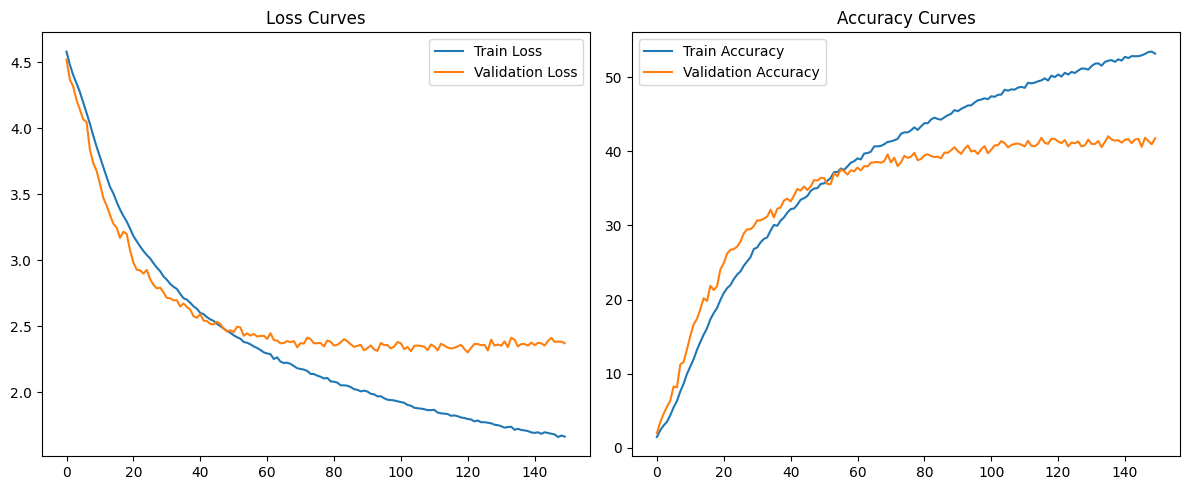

In [ ]:
import os

os.environ['WANDB_API_KEY'] = '9939516006b39c80fadfbc2c8b1f044b1c946537'
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import random
import wandb

wandb.login(key='9939516006b39c80fadfbc2c8b1f044b1c946537')

class DataAugmentation:
    def __init__(self):
        self.train_transforms = transforms.Compose([
            transforms.RandomCrop(32, padding=4),  #Translational augmentation is applied in order to increase model accuracy
            transforms.RandomHorizontalFlip(), # Horizontal flip augmentation 
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  #Color augmentation here
            transforms.ToTensor(),transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])
        self.test_transforms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))]) # Normalization for test data

class CIFAR100Dataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform 
        self.classes = sorted(os.listdir(data_dir))
        self.images = []
        self.labels = []
        for label, cls in enumerate(self.classes):
            cls_path = os.path.join(data_dir, cls)
            for img_name in os.listdir(cls_path):
                self.images.append(os.path.join(cls_path, img_name))
                self.labels.append(label)
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

class CIFAR100CNN(nn.Module):
    def __init__(self, num_classes=100):
        super(CIFAR100CNN, self).__init__()
        
        self.features = nn.Sequential(
            # First Conv Block with batch normalization and ReLU activation. here i am applying 64 filters of size 3x3 with padding 1 and stride 1. With Relu activation and Maxpooling of size 2x2.
            nn.Conv2d(3, 64, kernel_size=3, padding=1),nn.BatchNorm2d(64),nn.ReLU(inplace=True),nn.Conv2d(64, 64, kernel_size=3, padding=1),nn.BatchNorm2d(64),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=2, stride=2), 
            
            # Second Conv Block. Here i am applying 128 filters of size 3x3 with padding 1 and stride 1. The increase in filter from 64 to 128 is because in second block, more features are extracted from the input image.
            nn.Conv2d(64, 128, kernel_size=3, padding=1),nn.BatchNorm2d(128),nn.ReLU(inplace=True),nn.Conv2d(128, 128, kernel_size=3, padding=1),nn.BatchNorm2d(128),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Third Conv Block with 256 filters of size 3x3 with padding 1 and stride 1. The increase in filter from 128 to 256 is because in third block.
            nn.Conv2d(128, 256, kernel_size=3, padding=1),nn.BatchNorm2d(256),nn.ReLU(inplace=True),nn.Conv2d(256, 256, kernel_size=3, padding=1),nn.BatchNorm2d(256),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=2, stride=2))
        # Maxpool2d(kernel_size=2, stride=2) is used to reduce the spatial dimensions by half.
        
        # Fully Connected Layers for Classification. Here we have 3 FC layers and 2 dropout layers. Dropout is used for regularization.
        self.classifier = nn.Sequential(nn.Linear(256 *4* 4, 512),nn.ReLU(inplace=True),nn.Dropout(0.5),nn.Linear(512, 256),nn.ReLU(inplace=True),nn.Dropout(0.3),nn.Linear(256, num_classes))
        # in order to avoid overfitting, dropout is used. Dropout is a regularization technique where during training, randomly selected neurons gets ignored.
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Denormalization Transform is used to convert normalized images back to original images. This is performed to check the data augmentation and visualize the images. The mean and standard deviation values are taken from the CIFAR-100 dataset. This mean value is subtracted and the standard deviation is divided to get the original image. This is used to plot the image grid.
def denormalize(tensor):
    mean = [0.5071, 0.4867, 0.4408]
    std = [0.2675, 0.2565, 0.2761]
    tensor = tensor.clone()
    for t,m,s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def imageGrid(dataset, num_classes=10, imgClass=5):
    selClass = random.sample(range(len(dataset.classes)), num_classes)
    grid_images = []
    grid_labels = []
    for cls in selClass:
        clsImg = [i for i in range(len(dataset)) if dataset.labels[i] == cls]
        selImg = random.sample(clsImg, imgClass)
        for img_index in selImg:
            img, label = dataset[img_index]
            grid_images.append(img)
            grid_labels.append(label)
    grid = vutils.make_grid([denormalize(img) for img in grid_images],nrow=imgClass,padding=2,normalize=True)
    plt.figure(figsize=(15, 6))
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.title('CIFAR-100 Image Grid')
    plt.tight_layout()
    plt.show()

def trainCNN(loadTrain, loadVal, model, criterion, optimizer, totEpochs=150):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    wandb.init(project="CIFAR-100-CNN", config={"learning_rate": 0.001,"batch_size": loadTrain.batch_size,"epochs": totEpochs})
    
    trainL, trainA = [], []
    valL, valA = [], []
    
    for epoch in range(totEpochs):
        print(f"Processing Epoch {epoch+1}/{totEpochs}")
        model.train()
        trainLoss, trainCorr, trainTot = 0, 0, 0
        for images, labels in loadTrain:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            trainLoss +=loss.item()
            _, predicted = torch.max(outputs.data, 1)
            trainTot +=labels.size(0)
            trainCorr +=(predicted ==labels).sum().item()
        resultAccT =100 *trainCorr/ trainTot
        avgTrainL= trainLoss/ len(loadTrain)
        
        model.eval()
        valLoss,valCorr,valTot = 0, 0, 0
        with torch.no_grad():
            for images, labels in loadVal:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels) 
                valLoss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                valTot += labels.size(0)
                valCorr += (predicted == labels).sum().item()
        resultAccV = 100 * valCorr/ valTot
        avgValL = valLoss /len(loadVal)
        
        wandb.log({"train_loss": avgTrainL,"train_accuracy": resultAccT,"val_loss": avgValL,"val_accuracy": resultAccV})
        
        trainL.append(avgTrainL)
        trainA.append(resultAccT)
        valL.append(avgValL)
        valA.append(resultAccV)
        print(f"Epoch {epoch+1}/{totEpochs}")
        print(f"Train Loss: {avgTrainL:.4f}, Train Accuracy: {resultAccT:.2f}%")
        print(f"Val Loss: {avgValL:.4f}, Val Accuracy: {resultAccV:.2f}%")
    wandb.finish()
    return trainL, trainA, valL, valA

def main():
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    augmentation = DataAugmentation()
    train_dataset = CIFAR100Dataset('/kaggle/working/processed_data/train', transform=augmentation.train_transforms)
    val_dataset = CIFAR100Dataset('/kaggle/working/processed_data/val', transform=augmentation.test_transforms)
    imageGrid(train_dataset)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
    model = CIFAR100CNN()
    print("Model Parameters:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name}: {param.shape} - {param.numel()} parameters")
    print("Model Summary:")
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Trainable Parameters: {total_params}")
    print(model)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses, train_accuracies, val_losses, val_accuracies = trainCNN(train_loader, val_loader, model, criterion, optimizer)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()